## Learning bi-partite motifs based on a thermodynamic approach
### Implements the dynamic programming and the gradient descent

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import itertools
import pandas as pd
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import check_grad
from scipy.special import logsumexp
from Bio import SeqIO
import random
import multiprocessing
import multiprocessing as mp
import ctypes
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import clear_output

%load_ext cython

#Load Robert Kern's line profiler
#%load_ext line_profiler
#import line_profiler

In [2]:
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()
directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

### cython

In [3]:
%%cython -f -I . --compile-args=-DCYTHON_TRACE=1 


cimport cython
import numpy as np
import itertools
from libc.math cimport exp,pow


cdef int l = 3 #l_A=l_B=3 nucleotides
cdef int l_p = 3 #persistence length is 3 nucleotides 
cdef double cpi = np.pi

cpdef generate_kmer_inx():
    cdef dict vals = {'A':0,'C':1,'G':2,'T':3}
    cdef dict kmer_inx = {}
    
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

kmer_inx = generate_kmer_inx()
inx_kmer = {y:x for x,y in kmer_inx.items()}

cpdef seq2int_cy(str sequence):
    cdef int L = len(sequence)
    kmer_array = np.zeros(L, dtype=int)
    
    cdef i
    for i in range(l-1,L):
        kmer = sequence[i-l+1:i+1]
        kmer_array[i] = kmer_inx[kmer]
    return kmer_array        


cpdef void assign_za_cy(long[:] x, int i, double[:] za, double[:] zb, double[:] Ea, double[:] Eb, double cab, double sf, double D, double sig):
    za[i] = (zb[i-l] + np.sum(za[:i-l+1])) * cab * exp(-Ea[x[i]])
    
cpdef void assign_zb_cy(long[:] x, int i, double[:] za, double[:] zb, double[:] Ea, double[:] Eb, double cab, double sf, double D, double sig):
    cdef double z = zb[i-1]
    cdef int j

    for j in range(0,i-l+1):
        z += za[j]*cb_c(i-j-l, sf, D, sig)*exp(-Eb[x[i]])
    z += zb[i-l]*cab*np.exp(-Eb[x[i]])      
    zb[i] = z 


cpdef void assign_za_E_derivatives_cy(long[:] x, int i, int inx, double[:] za, double[:] zb,
                                 double[:,:] za_Ea_derivatives, double[:,:] zb_Ea_derivatives, double[:,:] za_Eb_derivatives, double[:,:] zb_Eb_derivatives,
                                 double[:] Ea, double[:] Eb, double cab, double sf, double D, double sig):
    identical = (inx == x[i])
    
    za_Ea_derivatives[inx,i] = cab*(zb_Ea_derivatives[inx,i-l] + np.sum(za_Ea_derivatives[inx,:i-l+1]))*exp(-Ea[x[i]]) - cab*(zb[i-l] + np.sum(za[:i-l+1]))*identical*exp(-Ea[x[i]])
    za_Eb_derivatives[inx,i] = cab*(zb_Eb_derivatives[inx,i-l]+ np.sum(za_Eb_derivatives[inx,:i-l+1]))*exp(-Ea[x[i]])


cdef extern from "src_helper.c":
    pass
    
cdef extern from "src_helper.h":
    cdef void assign_zb_E_derivatives_c(long* x, int i, int inx, double* za, double* zb, int L, int l, double l_p,
                                 double* za_Ea_derivatives, double* zb_Ea_derivatives, double* za_Eb_derivatives, double* zb_Eb_derivatives,
                                 double* Ea, double* Eb, double cab, double sf, double D , double sig)
    cdef void assign_za_E_derivatives_c(long* x, int i, int inx, double* za, double* zb, int L, int l, double l_p,
                                 double* za_Ea_derivatives, double* zb_Ea_derivatives, double* za_Eb_derivatives, double* zb_Eb_derivatives,
                                 double* Ea, double* Eb, double cab, double sf, double D , double sig)
    cdef double cb_c(int, double, double, double)
    cdef double cb_D_derivative_c(int, double, double, double);
    cdef double cb_sig_derivative_c(int, double, double, double);
    cdef double cb_sf_derivative_c(int, double, double, double);
    
    
cpdef void assign_za_D_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_D_derivatives, double[:] zb_D_derivatives, double[:] Ea, double[:] Eb, 
                                     double cab, double sf, double D , double sig):
    za_D_derivatives[i] = (zb_D_derivatives[i-l]+np.sum(za_D_derivatives[:i-l+1]))*cab*exp(-Ea[x[i]])
    

cpdef void assign_za_sig_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_sig_derivatives, double[:] zb_sig_derivatives, double[:] Ea, double[:] Eb, 
                                       double cab, double sf, double D , double sig):
    za_sig_derivatives[i] = (zb_sig_derivatives[i-l]+np.sum(za_sig_derivatives[:i-l+1]))*cab*exp(-Ea[x[i]])    


cpdef void assign_za_sf_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_sf_derivatives, double[:] zb_sf_derivatives, double[:] Ea, double[:] Eb, 
                                      double cab, double sf, double D , double sig):
    za_sf_derivatives[i] = (zb_sf_derivatives[i-l]+np.sum(za_sf_derivatives[:i-l+1]))*cab*exp(-Ea[x[i]])    


cpdef void assign_zb_D_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_D_derivatives, double[:] zb_D_derivatives, double[:] Ea, double[:] Eb, 
                                     double cab, double sf, double D , double sig):
    cdef double der = 0
    cdef int j

    for j in range(0,i-l+1):
        der += za_D_derivatives[j]*cb_c(i-l-j, sf, D, sig) + za[j]*cb_D_derivative_c(i-l-j, sf, D, sig)
    der += zb_D_derivatives[i-l]*cab
    der *= exp(-Eb[x[i]])
    der += zb_D_derivatives[i-1]
    
    zb_D_derivatives[i] = der
    
cpdef void assign_zb_sig_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_sig_derivatives, double[:] zb_sig_derivatives, double[:] Ea, double[:] Eb, 
                                       double cab, double sf, double D , double sig):
    cdef double der = 0
    cdef int j

    for j in range(0,i-l+1):
        der += za_sig_derivatives[j]*cb_c(i-l-j, sf, D, sig) + za[j]*cb_sig_derivative_c(i-l-j, sf, D, sig)
    der += zb_sig_derivatives[i-l]*cab
    der *= exp(-Eb[x[i]])
    der += zb_sig_derivatives[i-1]
    
    zb_sig_derivatives[i] = der


cpdef void assign_zb_sf_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                             double[:] za_sf_derivatives, double[:] zb_sf_derivatives, double[:] Ea, double[:] Eb, 
                                      double cab, double sf, double D , double sig):
    cdef double der = 0
    cdef int j
    for j in range(0,i-l+1):
        der += za_sf_derivatives[j]*cb_c(i-l-j, sf, D, sig) + za[j]*cb_sf_derivative_c(i-l-j, sf, D, sig)
    der += zb_sf_derivatives[i-l]*cab
    der *= exp(-Eb[x[i]])
    der += zb_sf_derivatives[i-1]
    
    zb_sf_derivatives[i] = der

    
    
cpdef void assign_za_cab_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                                    double[:] za_cab_derivatives, double[:] zb_cab_derivatives, double[:] Ea, double[:] Eb, 
                                       double cab, double sf, double D , double sig):
    za_cab_derivatives[i] = exp(-Ea[x[i]])*((zb_cab_derivatives[i-l]+ np.sum(za_cab_derivatives[:i-l+1]))*cab + zb[i-l] + np.sum(za[:i-l+1]))
    
cpdef void assign_zb_cab_derivative_cy(long[:] x, int i, double[:] za, double[:] zb, 
                                    double[:] za_cab_derivatives, double[:] zb_cab_derivatives, double[:] Ea, double[:] Eb, 
                                       double cab, double sf, double D , double sig):
    cdef double der = 0
    cdef int j

    for j in range(0,i-l+1):
        der += za_cab_derivatives[j]*cb_c(i-l-j, sf, D, sig) + za[j]
        der += zb_cab_derivatives[j]*cab + zb[j]
    der *= exp(-Eb[x[i]])
    der += zb_cab_derivatives[i-1]
    
    zb_cab_derivatives[i] = der
    
    
def DP_Z_cy(double[:] args, long[:] x):
    
    cdef int L = len(x)
    cdef double cab = 1.0

    cdef double[:] Ea = args[0:len(kmer_inx)]
    cdef double[:] Eb = args[len(kmer_inx):2*len(kmer_inx)]
    cdef double sf = args[-3]
    cdef double D = args[-2]
    cdef double sig = args[-1]
    
    #initialization of statistical weigths
    cdef double[:] za = np.zeros(L)
    cdef double[:] zb = np.zeros(L)

    cdef int i
    for i in range(0,l):
        zb[i] = 1 

    #initialization of derivatives
    cdef double[:,::1] za_Ea_derivatives = np.zeros((len(kmer_inx),L))
    cdef double[:,::1] zb_Ea_derivatives = np.zeros((len(kmer_inx),L))

    cdef double[:,::1] za_Eb_derivatives = np.zeros((len(kmer_inx),L))
    cdef double[:,::1] zb_Eb_derivatives = np.zeros((len(kmer_inx),L))

    cdef double[:] za_sf_derivatives = np.zeros(L)
    cdef double[:] zb_sf_derivatives = np.zeros(L)
    
    cdef double[:] za_D_derivatives = np.zeros(L)
    cdef double[:] zb_D_derivatives = np.zeros(L)

    cdef double[:] za_sig_derivatives = np.zeros(L)
    cdef double[:] zb_sig_derivatives = np.zeros(L)


    cdef int inx
    #dynamic programming calculation of z and derivatives 
    for i in range(l,L):
        #calculate statistical weights
        assign_za_cy(x, i, za, zb, Ea, Eb, cab, sf, D, sig)
        assign_zb_cy(x, i, za, zb, Ea, Eb, cab, sf, D, sig)
        
        #calculate derivatives
        for inx in range(len(kmer_inx)):
            assign_za_E_derivatives_c(&x[0], i, inx, &za[0], &zb[0], L, l, l_p, 
                                      &za_Ea_derivatives[0,0], &zb_Ea_derivatives[0,0], &za_Eb_derivatives[0,0], &zb_Eb_derivatives[0,0], 
                                      &Ea[0], &Eb[0], cab, sf, D, sig)
            assign_zb_E_derivatives_c(&x[0], i, inx, &za[0], &zb[0], L, l, l_p, 
                                      &za_Ea_derivatives[0,0], &zb_Ea_derivatives[0,0], &za_Eb_derivatives[0,0], &zb_Eb_derivatives[0,0], 
                                      &Ea[0], &Eb[0], cab, sf, D, sig)
        
        
        assign_za_sf_derivative_cy(x, i, za, zb, za_sf_derivatives, zb_sf_derivatives, Ea, Eb, cab, sf, D, sig)
        assign_zb_sf_derivative_cy(x, i, za, zb, za_sf_derivatives, zb_sf_derivatives, Ea, Eb, cab, sf, D, sig)
        
        assign_za_D_derivative_cy(x, i, za, zb, za_D_derivatives, zb_D_derivatives, Ea, Eb, cab, sf, D, sig)
        assign_zb_D_derivative_cy(x, i, za, zb, za_D_derivatives, zb_D_derivatives, Ea, Eb, cab, sf, D, sig)
        
        assign_za_sig_derivative_cy(x, i, za, zb, za_sig_derivatives, zb_sig_derivatives, Ea, Eb, cab, sf, D, sig)
        assign_zb_sig_derivative_cy(x, i, za, zb, za_sig_derivatives, zb_sig_derivatives, Ea, Eb, cab, sf, D, sig)

    
    Z_x = zb[L-1] + np.sum(za)
    
    #derivative of Z(x)
    d_Ea = zb_Ea_derivatives[:,L-1] + np.sum(za_Ea_derivatives, axis=1)
    d_Eb = zb_Eb_derivatives[:,L-1] + np.sum(za_Eb_derivatives, axis=1)
    
    d_sf = zb_sf_derivatives[L-1] + np.sum(za_sf_derivatives)
    d_D = zb_D_derivatives[L-1] + np.sum(za_D_derivatives)
    d_sig = zb_sig_derivatives[L-1] + np.sum(za_sig_derivatives)
    
    
    gradient = np.concatenate([q.ravel() for q in [d_Ea, d_Eb, np.array([d_sf, d_D, d_sig])]])
    
    return Z_x, gradient

### implementation of the LL object

In [4]:
class nLL:
    def __init__(self, seqs_p, seqs_bg):
        
        self.N_p = len(seqs_p)
        self.N_bg = len(seqs_bg)

        #calculate background probabilities:

        #include positive sequences in bg sequences if not there
        X_bg_t = list(set(seqs_p + seqs_bg))  #number of unique sequences
        
        counts = np.zeros(len(X_bg_t))
        for i, x in enumerate(X_bg_t):
            counts[i] = seqs_bg.count(x)
            
        counts = counts + 1 #pseudocount to make sure 
        counts = counts/np.sum(counts)

        p_bg = dict(zip(X_bg_t, counts))

        self.pbg_xp = np.array([p_bg[x] for x in seqs_p])
        self.pbg_xbg = np.array([p_bg[xbg] for xbg in seqs_bg])
        
        #add a padding nucleotide to the beginning to make the calculations stable, binding starts at
        #position i=l so the padded nucleotide has no effect.
        self.X_p = [seq2int_cy('A' + x) for x in seqs_p] 
        self.X_bg = [seq2int_cy('A' + x) for x in seqs_bg]

        
    def assign_z_p(self, tup):
            i, args = tup
            d_z_x_np = np.frombuffer(dz.get_obj(), dtype=np.float64).reshape(-1, self.N_p)
            z[i], d_z_x_np[:,i] = DP_Z_cy(args, self.X_p[i])
            
    def assign_z_bg(self, tup):
            i, args = tup
            d_z_xbg_np = np.frombuffer(dz.get_obj(), dtype=np.float64).reshape(-1, self.N_bg)
            z[i], d_z_xbg_np[:,i] = DP_Z_cy(args, self.X_bg[i])

          

        
    def __call__(self, parameters):
        
        #number of positive variables (stacked at the end)
        n_pos = 3
        
        #exp parameters to make sure they are positive
        args = parameters.copy()
        args[-n_pos:] = np.exp(args[-n_pos:])
    
    
        #define weights and derivatives as a multiprocessing array
        z_x = mp.Array(ctypes.c_double, self.N_p)
        d_z_x = mp.Array(ctypes.c_double, (2*len(kmer_inx)+ n_pos)*self.N_p)

        z_xbg = mp.Array(ctypes.c_double, self.N_bg)
        d_z_xbg = mp.Array(ctypes.c_double, (2*len(kmer_inx)+ n_pos)*self.N_bg) 
        
        #parallelizing
        with multiprocessing.Pool(initializer=init, initargs=(z_x,d_z_x), processes=8) as pool:
            pool.map(self.assign_z_p, [(i, args) for i in range(len(self.X_p))])
        with multiprocessing.Pool(initializer=init, initargs=(z_xbg, d_z_xbg), processes=8)  as pool:
            pool.map(self.assign_z_bg, [(i, args) for i in range(len(self.X_bg))])
        
        #= convert to np array ======
        d_z_x = np.frombuffer(d_z_x.get_obj(), dtype=np.float64).reshape(-1, self.N_p)
        d_z_xbg = np.frombuffer(d_z_xbg.get_obj(), dtype=np.float64).reshape(-1, self.N_bg)
        z_x = np.frombuffer(z_x.get_obj(), dtype=np.float64)
        z_xbg = np.frombuffer(z_xbg.get_obj(), dtype=np.float64)
        #============================
        
        #calculate log likelihood of model given arg parameters
        ll = np.sum(np.log(self.pbg_xp) + np.log(np.ones(self.N_p) - (np.ones(self.N_p)/z_x)))
        ll -= self.N_p * logsumexp( np.log(self.pbg_xbg) + np.log(np.ones(self.N_bg) - (np.ones(self.N_bg)/z_xbg)) )
        
        #calculate partial derivatives of model given arg parameters
        dll = np.sum(d_z_x/(z_x*(z_x-1)), axis=1)
        dll -= self.N_p * ( np.sum((self.pbg_xbg * d_z_xbg)/(z_xbg*z_xbg), axis=1 ) / np.sum(self.pbg_xbg*(np.ones(self.N_bg) - (np.ones(self.N_bg)/z_xbg))))

        #exp modify dLL for positive elements
        dll[-n_pos:] = dll[-n_pos:]*args[-n_pos:]

        #regularize some parameters
        if True:
            comp = -3
            reg = 1e-8 
            ll -= np.power(args[comp],2)*reg
            dll[comp] -= 2*reg*args[comp]
        #print("final ll:\t%f"%ll)
        return -ll, -dll 

#make the arrays global to all processes
def init(z_array, dz_array):
    global z
    z = z_array    
    global dz
    dz = dz_array

In [5]:
def auc_evaluate(param, plus, bg):
    z_plus = np.zeros(len(plus))
    z_bg = np.zeros(len(bg))
    
    seq_pos = [seq2int_cy('A' + x) for x in plus]
    seq_bg = [seq2int_cy('A' + x) for x in bg]
    
    n_pos = 3
    #exp parameters to make sure they are positive
    args = param.copy()
    args[-n_pos:] = np.exp(args[-n_pos:])
        
    for i, x in enumerate(seq_pos):
        z_plus[i], _ = DP_Z_cy(args, x)
    
    for i, x in enumerate(seq_bg):
        z_bg[i], _ = DP_Z_cy(args, x)
        
    y_true = np.append(np.ones(len(plus)), np.zeros(len(bg)))
    y_score = np.append(z_plus, z_bg)
    
    auc = roc_auc_score(y_true, y_score)
    
    return auc

In [6]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [ ]:
def plt_performance(auc_validation, auc_train, theta):
        
    x = np.arange(0, len(auc_validation), 1)
    
    fig, ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.set_ylabel('AUC')
    
    x_max = max(30, len(auc_validation))
    
    ax.set_xlim(0,x_max)
    ax.set_ylim(0.4,1)
    
    # get current motif ===========
    core1 = {}
    for i in range(len(kmer_inx)):
        core1[inx_kmer[i]] = theta[i]

    core1 = pd.Series(core1).sort_values(ascending=True)
    
    core2 = {}
    for i in range(len(kmer_inx)):
        core2[inx_kmer[i]] = theta[i+64]
    core2 = pd.Series(core2).sort_values(ascending=True)
    #==============================

    ax.set_title('current core1 motif: %s %.2f, %s %.2f\ncurrent core2 motif: %s %.2f, %s %.2f\ncurrent validation AUC: %.3f'%(
        core1.index[0],core1.values[0], core1.index[1], core1.values[1], core2.index[0], core2.values[0], core2.index[1], core2.values[1], auc_validation[-1]))
    ax.plot(x, auc_validation, color='blue', label='validation set ')  
    ax.plot(x, auc_train, color='red', label='training set')
    ax.legend()
    
    clear_output(wait=True)
    plt.show()

In [65]:
def optimize_adam(plus, bg, plus_valid=None, bg_valid=None):

    #number of minibatches
    n_batch = 10
    
    #adam parameters
    alpha = 0.01
    beta_1 = 0.9
    beta_2 = 0.999   
    epsilon = 1e-8

    #initialize the vector
    theta_0 = parameters  
    n_param = len(parameters)

    m_t = np.zeros(n_param) 
    v_t = np.zeros(n_param)  

    t = 0
    f_t = 42 #initialize with random number
    epoch = 0

    evaluate = plus_valid is not None
    

    #auc array tracks auc values
    auc_validation = []
    auc_train = []
    
    while(True):
        
        #split data into several minibatches
        epoch += 1
        #print('epoch = %d'%epoch)
        pos_batches = partition(plus, n_batch)
        bg_batches  = partition(bg, n_batch)

        #enumerate minibatches
        for i in range(n_batch):

            nll_obj = nLL(pos_batches[i],bg_batches[i])

            t+=1

            f_prev = f_t

            #computes the gradient of the stochastic function
            f_t, g_t = nll_obj(theta_0) 

            #updates the moving averages of the gradient
            m_t = beta_1*m_t + (1-beta_1)*g_t 

            #updates the moving averages of the squared gradient
            v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) 

            #calculates the bias-corrected estimates
            m_cap = m_t/(1-(beta_1**t)) 

            #calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**t)) 

            #before updating parameters plot performance on validation set
            if evaluate and i==0:
                aucv = auc_evaluate(theta_0, plus_valid, bg_valid)
                auct = auc_evaluate(theta_0, plus, bg)
                auc_validation.append(aucv)
                auc_train.append(auct)
                plt_performance(auc_validation, auc_train, theta_0)
                
                
            #updates the parameters by moving a step towards gradients
            theta_0_prev = theta_0 
            theta_0 = theta_0 - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon) 

            if(theta_0 == theta_0_prev).all(): #checks if it is converged or not
                print("parameters converged")
                return theta_0

            if(f_prev == f_t).all():
                print("LL converged")
                return theta_0          
        #callb(theta_0)

### Import fasta files

In [42]:
def parse_fasta(file_name):
    input_seq_iterator = SeqIO.parse(file_name, "fasta")
    return [str(record.seq) for record in input_seq_iterator]

In [43]:
def swap_cores (args):
    core1_args = args[:len(kmer_inx)]
    core2_args = args[len(kmer_inx):len(kmer_inx)*2]
    return np.concatenate([x.ravel() for x in [core2_args, core1_args, np.array([args[-2], args[-1]])]])

In [44]:
if False:
    set_size = 100
    bg = parse_fasta('HNRNPA0_1_TGTCGA40NCCGA_AAG_1.fasta.tmp')
    plus = parse_fasta('HNRNPA0_4_TGTCGA40NCCGA_AAG_4.fasta.tmp')

    bg = random.sample(bg, set_size)
    plus = random.sample(plus, set_size)
    
    bg   = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in bg]
    plus = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in plus]
    
else:
    background_set = parse_fasta('negatives_toy.fasta')
    positive_set = parse_fasta('positives_toy.fasta')
    
    bg_train, bg_test, bg_valid = partition(background_set, 3)
    pos_train, pos_test, pos_valid = partition(positive_set, 3)

In [63]:
#np.random.seed(0)
Ea = np.random.uniform(low=8, high=12, size=len(kmer_inx))
Eb = np.random.uniform(low=8, high=12, size=len(kmer_inx))
sf = np.log(100)
D = np.log(3)
sig = np.log(3)

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, D, sig])]])

### ADAM optimization

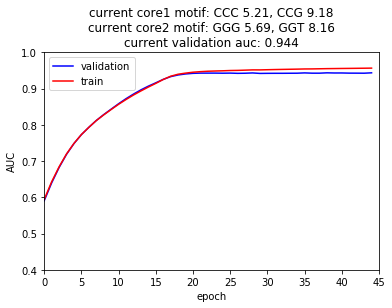

Process ForkPoolWorker-361650:
Process ForkPoolWorker-361651:
Process ForkPoolWorker-361649:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/salma/anaconda3/envs/rbp_motif/lib/python3.6/multi

In [66]:
%matplotlib inline
n=1000
optimize_adam(pos_train[:n], bg_train[:n], pos_valid[:n], bg_valid[:n])

### LBFGS optimization

In [67]:
auc_validation = []
auc_train = []

def callb(theta):
    aucv = auc_evaluate(theta, pos_valid, bg_valid)
    auct = auc_evaluate(theta, pos_train, bg_train)
    auc_validation.append(aucv)
    auc_train.append(auct)
    
    plt_performance(auc_validation, auc_train, theta)

In [68]:
nll_obj = nLL(pos_train[:n], bg_train[:n])

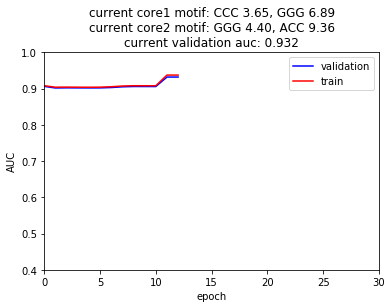

In [69]:
x_opt, fx, info = fmin_l_bfgs_b(nll_obj, x0=parameters, callback=callb, factr=1, iprint=5)

In [70]:
info

{'grad': array([-1.72416976e-02, -1.10463718e-01, -5.82362312e-03, -3.48828536e-02,
        -4.13195806e-03, -1.32842780e-04, -4.57016331e-02, -1.90869417e-02,
        -2.46043475e-02, -1.19030239e-01, -8.83433537e-03, -1.74364032e-02,
        -3.17053700e-02, -2.58470699e-02, -1.72653810e-02, -1.54380129e-02,
        -6.03652233e-02, -8.03525010e-03, -1.35429978e-01, -2.23549298e-02,
        -1.36982950e-01,  1.95189845e+01, -4.41847324e-02, -3.91467429e-04,
        -6.34759379e-03, -2.86536127e-02, -2.19083076e-01, -1.73093533e-02,
        -6.36284952e-03, -6.33545314e-02, -2.79363745e-02, -1.67099987e-02,
        -1.56217560e-02, -2.02442983e-02, -7.94368069e-03, -2.36569052e-03,
        -1.31572209e-02, -7.77023432e-03, -5.73514583e-03, -4.00858867e-02,
        -3.13978678e-03, -7.23745823e-02, -2.70868913e+00, -4.48839862e-03,
        -1.31280962e-02, -4.82935743e-03, -1.05424356e-02, -2.31988446e-02,
        -1.94025922e-02, -1.17000316e-03, -1.17660909e-02, -2.77899137e-02,
    

In [71]:
np.exp(x_opt[-3:])

array([179.82243367,   2.00107488,   1.54079172])

In [ ]:
core1 = {}
for i in range(len(kmer_inx)):
    core1[inx_kmer[i]] = x_opt[i]

pd.Series(core1).sort_values(ascending=True)

In [ ]:
core2 = {}
for i in range(len(kmer_inx)):
    core2[inx_kmer[i]] = x_opt[i+64]
pd.Series(core2).sort_values(ascending=True)

In [ ]:
nll_obj(x_opt)

### Evaluate gradients

In [21]:
param = parameters
intrep = seq2int_cy(plus[20])

for comp in [0,127,128,129,130]:
    epsilon = 1e-5
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = DP_Z_cy(x_fwd, intrep)[0]
    fx_rev = DP_Z_cy(x_rev, intrep)[0]
    
    print('component %d'%comp)
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(DP_Z_cy(param, intrep)[1][comp])

component 0
0.0
0.0
component 127
-0.00013661644038265308
-0.00013661643089069622
component 128
4.9238391142125686e-08
4.9221867283524847e-08
component 129
9.86766224286839e-08
9.87268101479782e-08
component 130
-6.508127370352668e-08
-6.508425866948812e-08


In [23]:
param = np.log(parameters)
param = parameters
for comp in [0, 127,128,129,130]:
    epsilon = 1e-7
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = nll_obj(x_fwd)[0]
    fx_rev = nll_obj(x_rev)[0]
    
    print('component %d\t, 1=%f, 2=%f'%(comp, fx_fwd, nll_obj(param)[0]))
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(nll_obj(param)[1][comp])

component 0	, 1=73.787589, 2=73.787589
0.05244743306320743
0.05244675990695298
component 127	, 1=73.787589, 2=73.787589
0.6708569344482385
0.6708735725800907
component 128	, 1=73.787589, 2=73.787589
0.020000143763354572
0.00020000000000004343
component 129	, 1=73.787589, 2=73.787589
-3.552713678800501e-07
9.107298248878239e-18
component 130	, 1=73.787589, 2=73.787589
2.842170943040401e-07
-1.3010426069826055e-17
